In [9]:
FILE_PATH = '/Users/tony/Desktop/podslushano_texts/'

In [183]:
import numpy as np
import tqdm
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (8, 8)
import seaborn as sns
import pickle
import os
import torch
import torch.optim as optim
from torch import nn
import torch.functional as F
import os
import json
import torchtext
import pymorphy2
import time

In [17]:
dat = json.load(open(os.path.join(FILE_PATH, 'podslushano_104k_texts'), mode='r', encoding='utf-8'))


Рассмотрим примеры текстов с тегами

In [22]:
for i in dat[:5]:
    print(i[0])
    print(i[1])
    print('')

Чернуха
Рассказал подруге о своей первой любви. Всё как по канону: влюбился по самые уши, жить не могу, она прекрасна и всё такое. Так произошло, что после нашей последней встречи произошла утечка газа, взрыв, её с ожогами увезли за границу. После моего душевного рассказа подруга сказала: "Между вами мелькали искры".

Детство
У меня мало хороших воспоминаний о папе. Но это помню отлично. Мне четыре, сделала самолёт из длинного большого пинцета и плетёной детской корзинки. Самолёт должен был сесть, и я не придумала места лучше, чем розетка. Я воткнула пинцет в розетку и во всей квартире вырубился свет. Током меня не ударило. Прибежала мать, орала на меня, хотела отшлепать, но вмешался папа и сразу стал осматривать меня и спрашивать, все ли хорошо. Я очень дорожу этим воспоминанием.

Смешное
Я думаю, у каждого парня есть что-то, что заставляет охладить свое траханье. Не знаю, у кого что, а у меня это дядюшка Сталин, который почесывает усики.

Странное
Однажды ехал в троллейбусе после уни

Нормализуем тексты (примерно час времени)

In [167]:
morph = pymorphy2.MorphAnalyzer()
morph_texts_list = []
for i in tqdm.tqdm(dat):
    i[1] = re.sub(r"([\w/'+$\s-]+|[^\w/'+$\s-]+)\s*", r"\1 ", i[1])
    a = [morph.parse(j)[0].normal_form for j in i[1].split()]
    morph_texts_list.append([' '.join(a), i[0]])

100%|██████████| 104250/104250 [1:01:18<00:00, 28.34it/s]


Загрузим список стоп-слов

In [215]:
with open(os.path.join(FILE_PATH, 'stop-words-russian.txt'), mode='r', encoding='utf-8') as f:
    stop_w = f.readlines()
stop_w = [i.replace('\n', '') for i in stop_w]

Составим датафрейм для подачи в torchtext

In [223]:
dat_df = pd.DataFrame()
a = []
b = []
for i in tqdm.tqdm(morph_texts_list):
    k = ' '.join([j for j in i[0].split() if j not in stop_w])  # убираем стоп-слова
    a.append(k)
    b.append(i[1])
dat_df['texts'] = a
dat_df['tags'] = b

100%|██████████| 104250/104250 [00:40<00:00, 2572.44it/s]


In [236]:
# # Сохраняем весь датафрейм
# dat_df.to_csv(os.path.join(FILE_PATH, 'all_parsed_dataframe.csv'), index=False)

Составим train и test

In [246]:
_ = np.random.permutation(np.arange(dat_df.shape[0]))
tr_index, te_index = np.split(_, [int(np.floor(0.9*len(dat_df)))])

dat_train_df = dat_df.loc[tr_index]
dat_test_df = dat_df.loc[te_index]

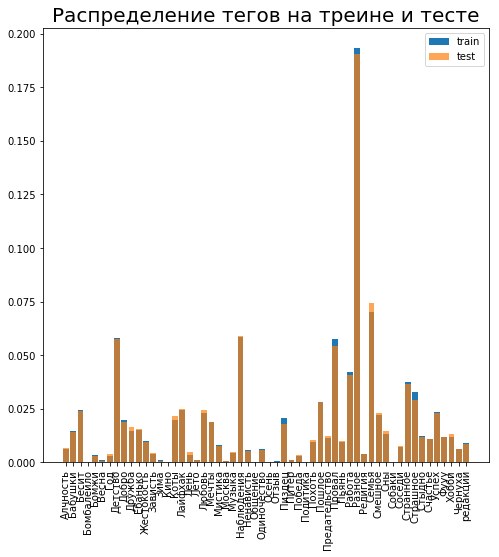

In [260]:
a, b = np.unique(dat_train_df.tags.values, return_counts=True)
plt.bar(a, b/b.sum(), label='train')
plt.xticks(np.arange(a.shape[0]), a, rotation=90);
c, d = np.unique(dat_test_df.tags.values, return_counts=True)
plt.bar(a, d/d.sum(), label='test', alpha=0.7)
plt.xticks(np.arange(a.shape[0]), a, rotation=90);
plt.title(u'Распределение тегов на треине и тесте', fontsize=20)
plt.legend();

In [261]:
# # Сохраняем треин и тест
# dat_train_df.to_csv(os.path.join(FILE_PATH, 'data_train.csv'), index=False)
# dat_test_df.to_csv(os.path.join(FILE_PATH, 'data_test.csv'), index=False)

Составляем препроцессоры для составление батчей

In [234]:
from torchtext.data import Field
tokenize = lambda x: x.split()
TEXT = Field(sequential=True, tokenize=tokenize, lower=True)
LABEL = Field(sequential=False, use_vocab=False)

Составляет train и test

In [262]:
from torchtext.data import TabularDataset
 
tv_datafields = [("texts", TEXT), ("tags", LABEL)]
trn = TabularDataset(
           path=os.path.join(FILE_PATH, 'data_train.csv'), # the file path
           format='csv',
           skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
           fields=tv_datafields)
 
tst_datafields = [("texts", TEXT), ("tags", LABEL)]
tst = TabularDataset(
           path=os.path.join(FILE_PATH, 'data_test.csv'), # the file path
           format='csv',
           skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
           fields=tst_datafields)

 Составляем словарь

In [299]:
TEXT.build_vocab(trn, max_size=20000)
LABEL.build_vocab(trn)

Составляет батч итератор

In [330]:
train_iter = BucketIterator(dataset=trn, batch_size=100,
                                     sort_key=lambda x: len(x.texts))
next(iter(train_iter))

ValueError: invalid literal for int() with base 10: 'Пьянь'

In [301]:
from torchtext.data import Iterator, BucketIterator
 
train_iter, test_iterator = BucketIterator.splits(
 (trn, tst), # we pass in the datasets we want the iterator to draw data from
 batch_sizes=(100, 100),
 device='cpu', # if you want to use the GPU, specify the GPU number here
 sort_key=lambda x: len(x.texts), # the BucketIterator needs to be told what function it should use to group the data.
 sort_within_batch=True,
 repeat=False # we pass repeat=False because we want to wrap this Iterator layer.
)
# test_iter = Iterator(tst, batch_size=100, 
#                      device='cpu', sort=False, 
#                      sort_within_batch=True, repeat=False)

class BatchWrapper:
      def __init__(self, dl, x_var, y_vars):
            self.dl, self.x_var, self.y_vars = dl, x_var, y_vars # we pass in the list of attributes for x &amp;amp;amp;amp;lt;g class="gr_ gr_3178 gr-alert gr_spell gr_inline_cards gr_disable_anim_appear ContextualSpelling ins-del" id="3178" data-gr-id="3178"&amp;amp;amp;amp;gt;and y&amp;amp;amp;amp;lt;/g&amp;amp;amp;amp;gt;
  
      def __iter__(self):
            for batch in self.dl:
                x = getattr(batch, self.x_var) # we assume only one input in this wrapper
                  
                if self.y_vars is not None:
                    y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_vars], dim=1).float()
                else:
                    y = torch.zeros((1))
 
                yield (x, y)
  
      def __len__(self):
            return len(self.dl)
        
train_dl = BatchWrapper(train_iter, "texts", ["tags"])
test_dl = BatchWrapper(test_iter, "texts", ['tags'])


In [302]:
a = next(train_iter.__iter__())

ValueError: invalid literal for int() with base 10: 'Мечты'